**Task 3**

**Question 1**

Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side)

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [32]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [33]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


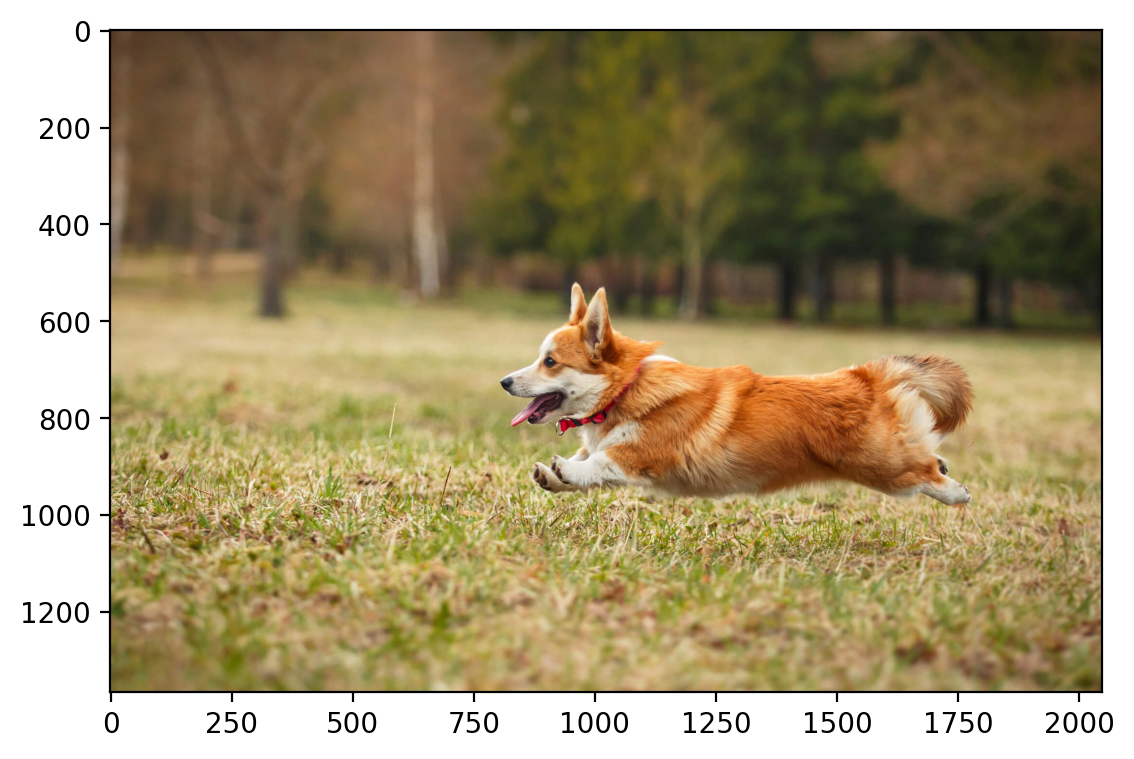

In [34]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [35]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [36]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [37]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [38]:
import cv2

In [39]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

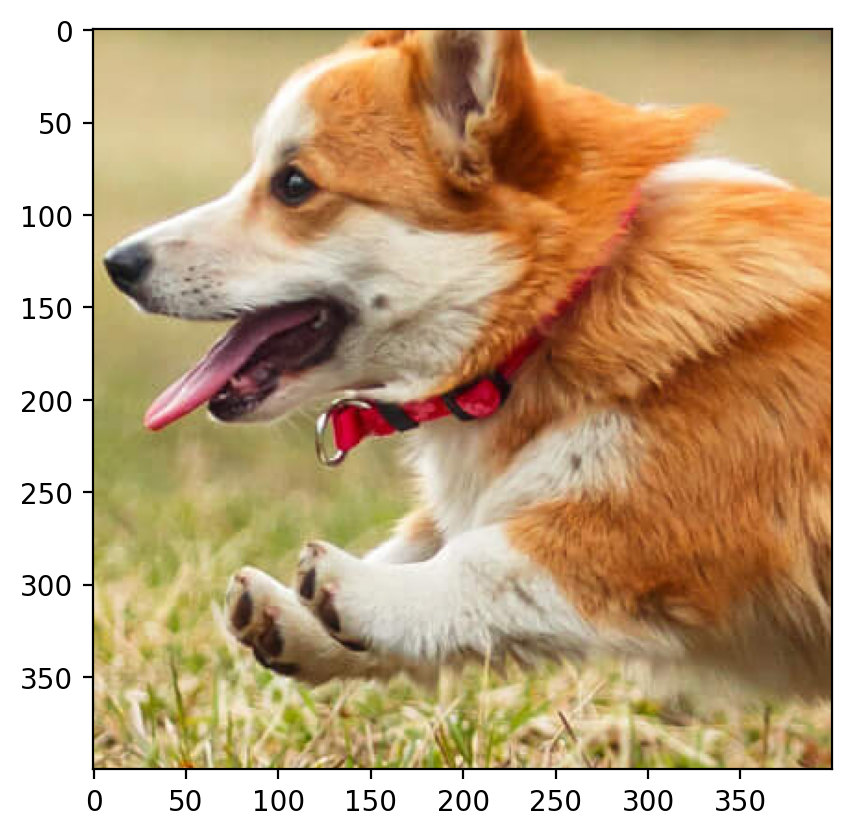

In [40]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [41]:
crop_np = crop.permute(1, 2, 0).numpy()

# Step 2: Resize the image using OpenCV (resize to 200x200 for example)
resized_np = cv2.resize(crop_np, (200, 200))

# Step 3: Convert the resized NumPy array back to a PyTorch tensor
# Convert it back to tensor with channels first
resized_tensor = torch.tensor(resized_np).permute(2, 0, 1)

# Print shape to confirm
print(resized_tensor.shape)

torch.Size([3, 200, 200])


In [42]:
resized_crop_tensor_back = resized_tensor.to(device)

In [43]:
# Get the dimensions of the image tensor
num_channels, height, width = resized_crop_tensor_back.shape
print(num_channels, height, width)

3 200 200


In [44]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [45]:
X.shape

torch.Size([12, 2])

In [46]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [47]:
dog_X, dog_Y = create_coordinate_map(resized_crop_tensor_back)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [48]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [49]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [50]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)

In [51]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [74]:
X_rff = create_rff_features(dog_X_scaled, 2000, 0.008)

In [75]:
X_rff.shape

torch.Size([40000, 2000])

In [76]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [77]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 1500)

Epoch 0 loss: 0.375326
Epoch 100 loss: 0.071017
Epoch 200 loss: 0.032790
Epoch 300 loss: 0.030217
Epoch 400 loss: 0.030058
Epoch 500 loss: 0.030028
Epoch 600 loss: 0.030017
Epoch 700 loss: 0.030013
Epoch 800 loss: 0.030011
Epoch 900 loss: 0.030011
Epoch 1000 loss: 0.030010
Epoch 1100 loss: 0.030010
Epoch 1200 loss: 0.030010
Epoch 1300 loss: 0.030010
Epoch 1400 loss: 0.030010


0.030010171234607697

**Question 2**

Quantitative comparison

RMSE on predicted v/s ground truth high resolution image
Peak SNR on predicted v/s ground truth high resolution image

In [66]:
# Generate coordinates for the 400x400 image
X_400, _ = create_coordinate_map(crop)

In [79]:
# Normalize and generate RFF features for 400x400 image
X_400_scaled = scaler_X.transform(X_400.cpu())
X_400_rff = create_rff_features(torch.tensor(X_400_scaled).to(device), 2000, 0.008)

In [80]:
# Predict the 400x400 pixel values using the trained model
net.eval()
with torch.no_grad():
    predicted_Y_400 = net(X_400_rff)

# Reshape the prediction back to (400, 400, 3)
predicted_img_400 = predicted_Y_400.reshape(400, 400, 3).cpu().numpy()

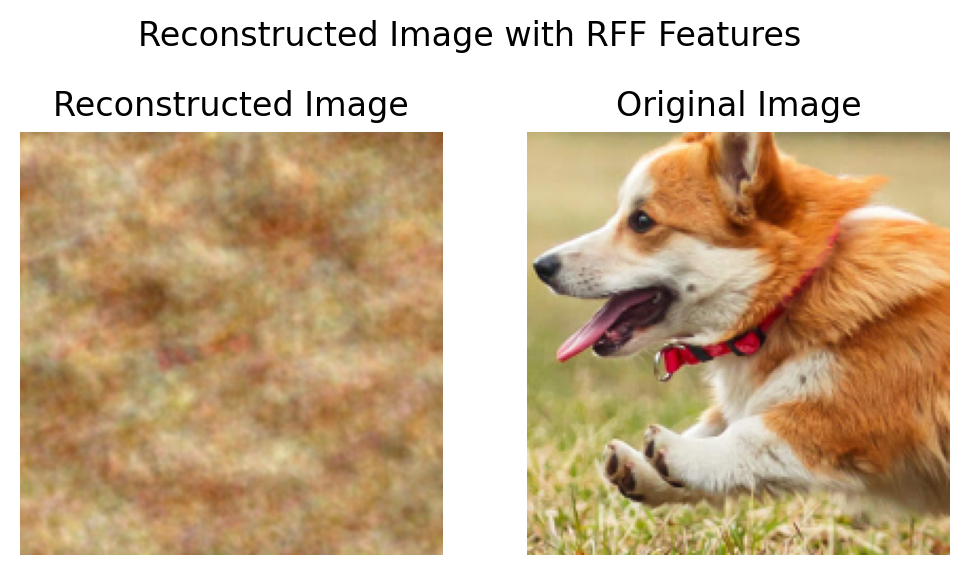

In [81]:
plot_reconstructed_and_original_image(resized_crop_tensor_back, net, X_rff, title="Reconstructed Image with RFF Features")

In [82]:
from sklearn.metrics import mean_squared_error
import math
import numpy as np

def compute_metrics(original_img, predicted_img):
    
    # Flatten the images for RMSE calculation
    original_flat = original_img.flatten()
    predicted_flat = predicted_img.flatten()

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(original_flat, predicted_flat))

    # Compute PSNR
    mse = np.mean((original_flat - predicted_flat) ** 2)
    if mse == 0:
        psnr_value = float('inf')
    else:
        max_pixel = 1.0  # Assuming pixel values are normalized between 0 and 1
        psnr_value = 20 * math.log10(max_pixel / math.sqrt(mse))

    return rmse, psnr_value

# Example usage:
original_img_np = crop_np  # Convert original image to numpy array
predicted_img_np = predicted_img_400  # Predicted image (already in numpy)

rmse, psnr_value = compute_metrics(original_img_np, predicted_img_np)
print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value}")


RMSE: 0.20995511491712457
PSNR: 13.557470812688129
